In [12]:
# Settings for autoreloading
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A Physics Informed Neural Network (PINN) practical example - The Inertial Oscillator

Example inspired by [Ben Moseley post](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/).

## Physical formalization

$$
F = m\dfrac{d^2 x}{d t^2}~,~~~~~
F_{spring} = -\mu \dfrac{d x}{d t}~,~~~~~
F_{friction} = -kx~,\\
F = F_{spring} + F_{friction}
$$

$$
⇓
$$

$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$

with the initial conditions

$$
x(0) = x_0~,~~\dfrac{d x}{d t}|_{t=0} = v_0~.
$$

The example will consider the underdamped case:

$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

This has the following exact solution:

$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

Reference: [Damped Harmonic Oscillator](https://beltoforion.de/en/harmonic_oscillator/)

In [13]:
# Import libraries
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from dotenv import load_dotenv
from IPython.display import Image as IPyImage

sys.path.append("../src")

from models import InertialOscillatorLoss, NeuralNetwork
from physics.inertial_oscillator import underdamped_oscillator
from utils import plot_result, remove_files, save_gif_pil


In [14]:
# Load paths
load_dotenv()

temp_plot_dir_path = Path(os.environ["TEMP_PLOT_DIR"])
result_plot_dir_path = Path(os.environ["RESULT_PLOT_DIR"])

# If folders do not exist create them
if not temp_plot_dir_path.exists():
    temp_plot_dir_path.mkdir()

if not result_plot_dir_path.exists():
    result_plot_dir_path.mkdir()

In [15]:
# Select GPU to accelerate computations if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Runtime type: {device}")

if torch.cuda.is_available():
  print(f"Device: {torch.cuda.get_device_name(device)}")

Runtime type: cuda
Device: NVIDIA GeForce RTX 3060 Ti


## Data Generation

Underdamped oscillator motion parameters:
delta = 2.0, omega0 = 20.0


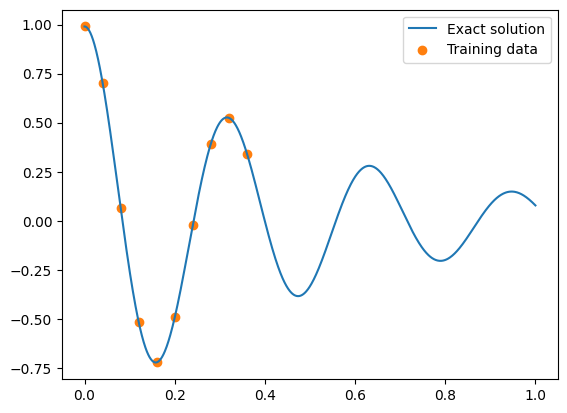

In [16]:
# Generate training data
max_t = 1
min_t = 0

m = 1
mu = 4
ke = 400
x0 = 1
v0 = 0

# Time domain vector
n_points = 1000
t = torch.linspace(min_t, max_t, n_points).reshape(-1, 1).to(device)

# Get the analitical solution over the full domain
x = underdamped_oscillator(m, mu, ke, x0, v0, t).reshape(-1, 1).to(device)

# Extract training data from the first part of the domain
n_data_points = 10
perc_range_data = 0.4
data_points_interval = int(n_points * perc_range_data)
step_data_points = int(data_points_interval / n_data_points)
t_data = t[:data_points_interval:step_data_points]
x_data = x[:data_points_interval:step_data_points]

# Plot the training data over the exact solution
plt.figure()
plt.plot(t.cpu(), x.cpu(), label="Exact solution")
plt.scatter(t_data.cpu(), x_data.cpu(), color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Purely Data-Driven Neural Network

In [17]:
# Set the seed for reproducibility
torch.manual_seed(0)

# NN hyperparameters
n_input = 1
n_layers = 3
n_hidden = 32
n_output = 1
activation = torch.nn.Tanh()
n_epochs = 20000
learning_rate = 0.0001

# Instantiate the NN and the optimizer
model = NeuralNetwork(n_input=n_input, n_layers=n_layers, n_hidden=n_hidden, n_output=n_output, activation_function=activation, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Data-driven loss function
loss_function = torch.nn.MSELoss()

# Helper variable to track the files created to generate the GIF
result_files = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # Prediction over data domain
    x_pred = model(t_data)

    # Computation of the data-driven loss
    loss = loss_function(x_pred, x_data)

    # Apply backpropagation and gradient descent step
    loss.backward()
    optimizer.step()

    # Keep track of the improvement during training
    if (epoch+1) % int(n_epochs / 50) == 0:
        x_pred_entire_domain = model(t).detach()

        plot_result(epoch, t, x, t_data, x_data, x_pred_entire_domain)

        file = temp_plot_dir_path / f"nn_{epoch+1:08d}.png"
        plt.savefig(file, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")
        result_files.append(file)

        plt.close("all")

# Save results and clean plots folder
save_gif_pil(result_plot_dir_path / "nn.gif", result_files, fps=30, loop=0)
remove_files(result_files)

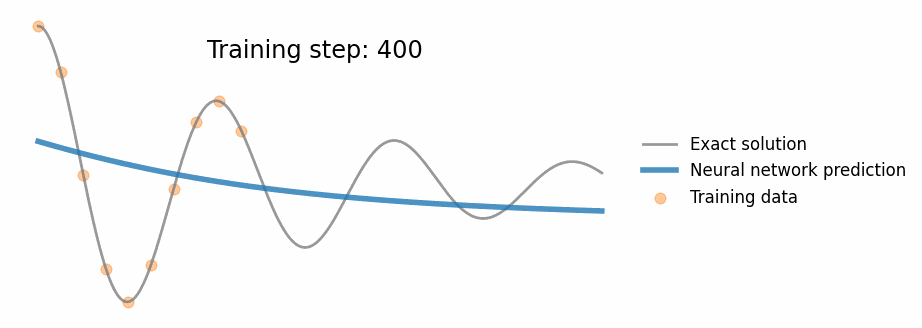

In [18]:
# Visualize nn.gif file
IPyImage(filename=result_plot_dir_path / "nn.gif")

## Physics Informed Neural Network

In [20]:
# Set the seed for reproducibility
torch.manual_seed(0)

# Sample collocation points over the problem domain
n_physics_points = 30
t_physics = torch.linspace(min_t,max_t,n_physics_points).reshape(-1,1).to(device).requires_grad_(requires_grad=True)

# Keep the same hyperparameters as the purely data-driven neural network
n_input = 1
n_layers = 3
n_hidden = 32
n_output = 1
activation = torch.nn.Tanh()
n_epochs = 20000
learning_rate = 1e-4

# Instantiate the PINN and the optimizer
pinn_model = NeuralNetwork(n_input=n_input, n_layers=n_layers, n_hidden=n_hidden, n_output=n_output, activation_function=activation, device=device)
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=learning_rate)

# Data-driven loss function
loss_function = torch.nn.MSELoss()

# Physics informed loss function
gamma = 1e-4
physics_loss_function = InertialOscillatorLoss(mu=mu, ke=ke, m=m)

# Helper variable to track the files created to generate the GIF
result_files = []

# Training loop
for epoch in range(n_epochs):
    pinn_model.train()
    optimizer.zero_grad()

    # Prediction over data domain
    x_pred = pinn_model(t_data)

    # Prediction over entire domain
    x_physics_pred = pinn_model(t_physics)

    # Computation of the data-driven and the physics informed losses
    data_loss = loss_function(x_pred, x_data)
    physics_loss = physics_loss_function(t_physics, x_physics_pred)
    loss = data_loss + gamma * physics_loss

    # Apply backpropagation and gradient descent step
    loss.backward()
    optimizer.step()

    # Keep track of the improvement during training
    if (epoch+1) % int(n_epochs / 50) == 0:
        x_pred_entire_domain = pinn_model(t).detach()
        plot_result(epoch, t, x, t_data, x_data, x_pred_entire_domain)

        file = temp_plot_dir_path / f"pinn_{epoch+1:08d}.png"
        plt.savefig(file, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")
        result_files.append(file)

        plt.close("all")

# Save results and clean plots folder
save_gif_pil(result_plot_dir_path / "pinn.gif", result_files, fps=30, loop=0)
remove_files(result_files)

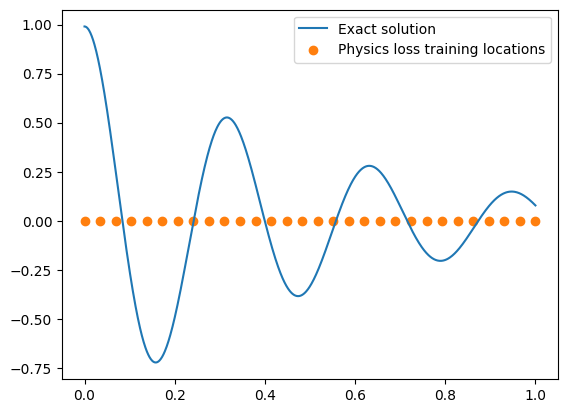

In [21]:
# Show collocation points
plt.figure()
plt.plot(t.cpu(), x.cpu(), label="Exact solution")
plt.scatter(t_physics.detach().cpu(), np.zeros_like(t_physics.detach().cpu()), color="tab:orange", label="Physics loss training locations")
plt.legend()

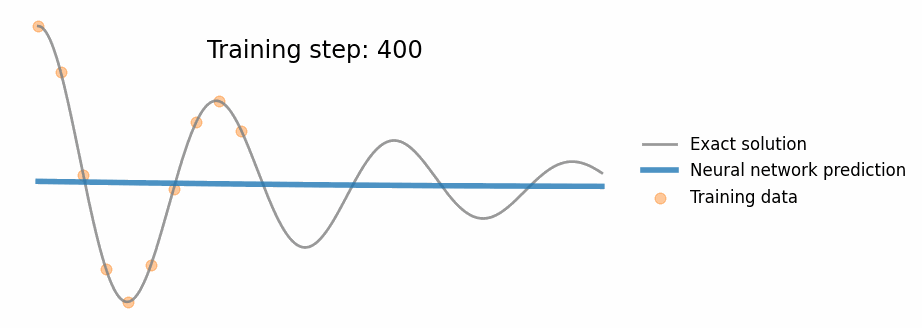

In [22]:
# Visualize nn.gif file
IPyImage(filename=result_plot_dir_path / "pinn.gif")